# **Hypothesis Testing With Insurance Data**

_John Andrew Dixon_

---

##### **Imports**

In [130]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
from statsmodels.stats.multicomp import pairwise_tukeyhsd

##### **Data Load**

In [107]:
# Remote URL to data
url = "https://docs.google.com/spreadsheets/d/e/2PACX-1vQ62VropqXZ6k0RwX0ErcJ-vwnCzfq2dD_vDiUEmaOyE4Xx8SW7dDkPoFa_LCH4zBsfrW6uinsvmgr_/pub?output=csv"
# Load the data
df = pd.read_csv(url)
# Verify
df.sample(5)

,age,sex,bmi,children,smoker,region,charges
1209,59,male,37.100,1,no,southwest,12347.17200
739,29,male,35.500,2,yes,southwest,44585.45587
618,19,female,33.110,0,yes,southeast,34439.85590
353,33,male,35.245,0,no,northeast,12404.87910
1069,54,female,31.900,1,no,southeast,10928.84900


--- 

## **Tests**

#### **_Do smokers have higher insurance charges than non-smokers?_**

##### _Hypotheses_

**Null Hypothesis:** There is no difference between insurance charges of non-smokers and insurance charges of smokers. 

**Alt. Hypothesis:** There is a difference between insurance charges of non-smokers and insurance charges of smokers, namely, that smokers have higher charges than non-smokers.

##### _Test Choice_

> There are two groups/samples we are comparing (smokers v. non-smokers). For each, we're comparing numerical data (amount charged). So, I perceive we will run a **Independent/2-Sample T-Test**.

> For this test I'll use an alpha value of 0.05.

##### _Test Assumptions_

Check and remove outliers:

In [108]:
# Get only smokers
smokers = df.loc[df["smoker"] == "yes", :]
# Get non-smokers
non_smokers = df.loc[df["smoker"] == "no", :]

In [109]:
# Reveal potential outliers
smokers_zscores = stats.zscore(smokers["charges"])
smokers_outliers = abs(smokers_zscores) > 3
print(f"There are {np.sum(smokers_outliers)} outliers for smokers")

There are 0 outliers for smokers


In [110]:
# Reveal potential outliers
non_smokers_zscores = stats.zscore(non_smokers["charges"])
non_smokers_outliers = abs(non_smokers_zscores) > 3
print(f"There are {np.sum(non_smokers_outliers)} outliers for non-smokers")

There are 24 outliers for non-smokers


In [111]:
# Remove non-smoker outliers
non_smokers = non_smokers.loc[~non_smokers_outliers, :]

Check for Normality:

In [112]:
result_smokers = stats.normaltest(smokers["charges"])
result_smokers

NormaltestResult(statistic=61.03941356533816, pvalue=5.564930630036463e-14)

In [113]:
result_non_smokers = stats.normaltest(non_smokers["charges"])
result_non_smokers

NormaltestResult(statistic=163.80367047789198, pvalue=2.6945416315543976e-36)

> The p-values for both groups are well below our defined alpha of 0.05. So, the data is not normally distributed. Now, to verify the size of each sample to see if it is sufficiently large to use without satisfying the test:

In [114]:
print("Non-smokers sample size:", len(non_smokers))
print("Smokers sample size:", len(smokers))

Non-smokers sample size: 1040
Smokers sample size: 274


> For this type of test, a sample size of 15 per group is sufficient to use without satisfying the test. In essence, we should be fine.

Check for Equal Variance:

In [115]:
result = stats.levene(smokers["charges"], non_smokers["charges"])
result

LeveneResult(statistic=520.7468821724297, pvalue=2.4247238784347824e-97)

> The variances are not equal. Because of this, we will need to add `equal_var = False` upon performing our test.

##### _Perform The Test_

In [116]:
result = stats.ttest_ind(smokers["charges"], non_smokers["charges"], equal_var=False)
result

Ttest_indResult(statistic=33.732305987092516, pvalue=2.575322662587431e-104)

> Our p-value is less than our alpha (0.05), so we reject the null hypothesis and conclude that there is a difference between insurance charges of non-smokers and insurance charges of smokers and smokers tend to have higher charges.

##### _Visual_

> The result of our test says that there is a remarkable difference in charges between smokers and non-smokers. A visual can help clear up which gets charged more:

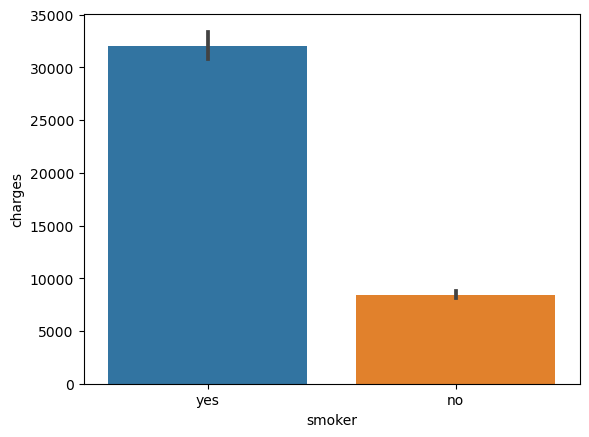

In [117]:
sns.barplot(data=df, x="smoker", y="charges");

> As shown above, the final answer to the question is yes, smokers have higher insurance charges than non-smokers.

##### **_Are men more likely to smoke than women?_**

##### _Hypotheses_

**Null Hypothesis:** There is no relationship between sex and smoker status.

**Alt. Hypothesis:** There is a relationship between sex and smoker status, namely, that men smoke more than women.

##### _Test Choice_

> There are two groups/samples we are comparing (men v. women). For each, we're comparing binary categorical data (smoker v. non-smoker). So, I perceive we will run a **Chi-Square Test**.

> For this test I'll use an alpha value of 0.05.

##### _Test Assumptions_

> The two variables we are considering are categorical in nature, namely they are nominal. Thus, the first assumption is met.

> The two variables we are considering are independent of one another. Thus, the second assumption is met.

##### _Perform The Test_

In [118]:
# Obtain the contingency table
cross_tab = pd.crosstab(df["sex"], df["smoker"])
cross_tab

smoker,no,yes
sex,,
female,547,115
male,517,159


In [119]:
# Perform the test
result = stats.chi2_contingency(cross_tab)
_, p, _, _ = result

In [120]:
print(p)
p < 0.05

0.006548143503580696


True

> Our p-value is less than our alpha (0.05), so we reject the null hypothesis and conclude that there is a relationship between sex and smoker status, namely, that men tend to smoke more than women.

##### _Visual_

> The result of our test says that there is a relationship between sex and smoker status. A visual can help us better understand which sex smokes more:

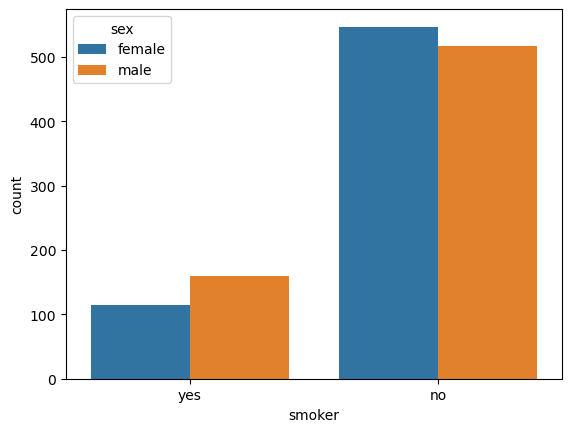

In [121]:
sns.countplot(data=df, x="smoker", hue="sex");

The above visual reinforces that men smoke more than women, since it directly shows that there are more men than women in the smoking section. On the other hands, there are more female non-smokers than males, further reinforcing this alternativ hypothesis.

##### **_Do different regions have different charges, on average?_**

##### _Hypotheses_

**Null Hypothesis:** On average, there is no difference in charges across regions.

**Alt. Hypothesis:** On average, there is a difference in charges across regions.

##### _Test Choice_

> There are multiple groups/samples we are comparing (many regions). For each, we're comparing numerical data (amount charged). So, I perceive we will run a **One-Way ANOVA Test** and then a **Tukey Test**.

> For this test I'll use an alpha value of 0.05.

##### _Test Assumptions_

Check and remove outliers:

In [122]:
# Define a dictionary with the regions
regions = {}

# Store the charge data from each region as a value and the region as the key
for region in df["region"].unique():
    data = df.loc[df["region"] == region, "charges"]
    regions[region] = data

# Show the keys
regions.keys()

dict_keys(['southwest', 'southeast', 'northwest', 'northeast'])

In [123]:
# Check for outliers
for region in regions.keys():
    # Get the zscores for the specific region
    zscores = stats.zscore(regions[region])
    # Get the outliers for the region
    outliers = abs(zscores) > 3
    # Display how much outliers there are
    print(f"There are {outliers.sum()} outliers for the {region} region")

    # If there are outliers, remove them.
    if outliers.sum():
        print("Removing them.")
        regions[region] = regions[region].loc[~outliers]

There are 8 outliers for the southwest region
Removing them.
There are 2 outliers for the southeast region
Removing them.
There are 7 outliers for the northwest region
Removing them.
There are 4 outliers for the northeast region
Removing them.


Check for Normality:

In [126]:
# Create a dictionary for region normal test results
region_norm_results = {}

# Iterate through all the regions
for key, values in regions.items():
    stat, p = stats.normaltest(values)
    region_norm_results[key] = {
        "n": len(values),
        "p": p,
        "test stat": stat
    }

# Make into a DataFrame for easy viewing
region_norm_results_df = pd.DataFrame(region_norm_results).T
region_norm_results_df

,n,p,test stat
southwest,317.0,7.728611e-22,97.223886
southeast,362.0,1.936990e-13,58.544942
northwest,318.0,2.940543e-19,85.341045
northeast,320.0,3.557877e-17,75.749565


> All the p-values are well under our alpha (0.05), meaning none of the data in any regions are of a normal distribution. However, each region has well over the required amount of samples (for One-way ANOVA, n >= 15) to ignore the data passing the normal test. Because of this, we can move on.

Check for Equal Variance:

In [127]:
stats.levene(*regions.values())

LeveneResult(statistic=9.518349004554441, pvalue=3.2035503711783993e-06)

> The p-value is well under our alpha (0.05), so the data for each region do not have equal variances. Thus, a non-parametric test must be used. 

##### _Perform The Test_

In [129]:
stats.kruskal(*regions.values())

KruskalResult(statistic=6.914045702545643, pvalue=0.07468847911322242)

> The non-parametric Kruskal test returned a p-value that is greater than our alpha (0.05). Thus, there is a difference in regional charges. Now, using the Tukey test, I'll see which regions show the difference.

In [132]:
tukeys_results = pairwise_tukeyhsd(df["charges"], df["region"])
tukeys_results.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
northeast,northwest,-988.8091,0.7245,-3428.9343,1451.3161,False
northeast,southeast,1329.0269,0.4745,-1044.9417,3702.9955,False
northeast,southwest,-1059.4471,0.6792,-3499.5723,1380.6781,False
northwest,southeast,2317.8361,0.0583,-54.1994,4689.8716,False
northwest,southwest,-70.638,0.9999,-2508.8826,2367.6066,False
southeast,southwest,-2388.4741,0.0477,-4760.5096,-16.4386,True


##### _Visual_

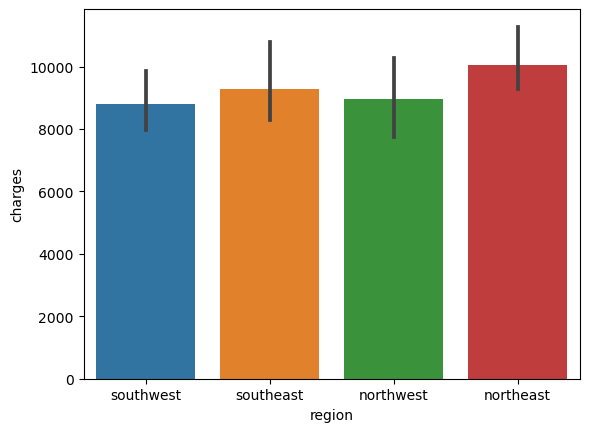

In [135]:
sns.barplot(data=df, x="region", y="charges", estimator="median");